In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install np_utils

Note: you may need to restart the kernel to use updated packages.


In [27]:
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [28]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [30]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [31]:
from skimage.transform import resize

In [32]:
X_train = np.array([resize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([resize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([resize(x, 
                                    (48, 48)) for x in X_test])

In [33]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

In [34]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [35]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [36]:
for layer in base_model.layers:
     layer.trainable = False

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [39]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [40]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [41]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [42]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/15
1328/1328 [==============================] - 87s 65ms/step - loss: 0.2353 - accuracy: 0.4666 - val_loss: 0.1884 - val_accuracy: 0.5776
Epoch 2/15
1328/1328 [==============================] - 87s 66ms/step - loss: 0.1973 - accuracy: 0.5670 - val_loss: 0.1759 - val_accuracy: 0.6177
Epoch 3/15
1328/1328 [==============================] - 90s 68ms/step - loss: 0.1853 - accuracy: 0.5950 - val_loss: 0.1687 - val_accuracy: 0.6277
Epoch 4/15
1328/1328 [==============================] - 90s 68ms/step - loss: 0.1773 - accuracy: 0.6183 - val_loss: 0.1634 - val_accuracy: 0.6396
Epoch 5/15
1328/1328 [==============================] - 90s 67ms/step - loss: 0.1706 - accuracy: 0.6333 - val_loss: 0.1607 - val_accuracy: 0.6482
Epoch 6/15
1328/1328 [==============================] - 92s 69ms/step - loss: 0.1657 - accuracy: 0.6456 - val_loss: 0.1616 - val_accuracy: 0.6468
Epoch 7/15
1328/1328 [==============================] - 92s 70ms/step - loss: 0.1616 - accuracy: 0.6569 - val_loss: 0.1564 -

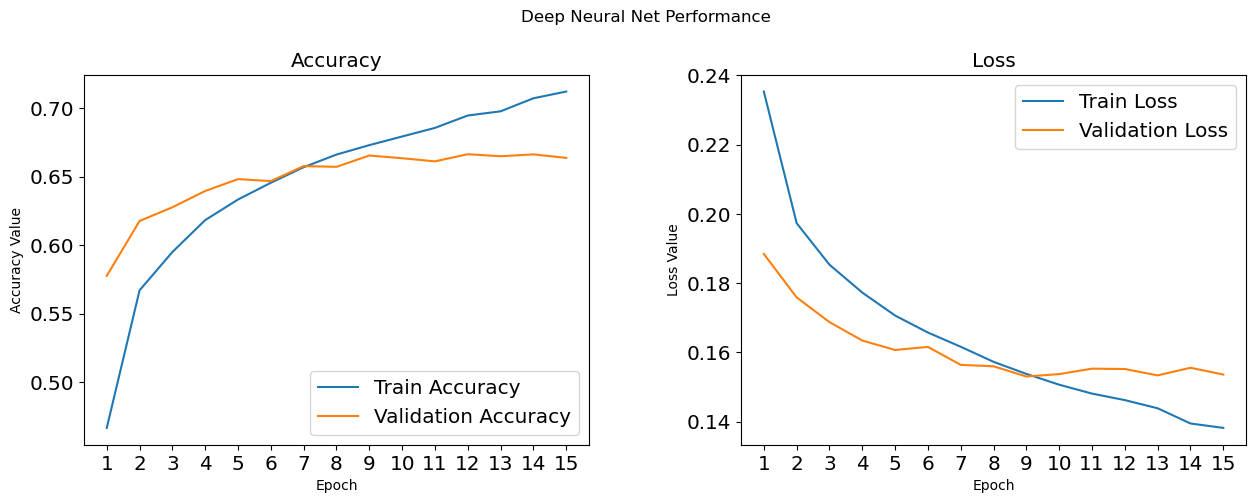

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [46]:

predictions = model.predict(X_test/255.)

313/313 [==============================] - 19s 60ms/step


In [47]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [48]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.6721
Precision: 0.6756
Recall: 0.6721
F1 Score: 0.672


In [49]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

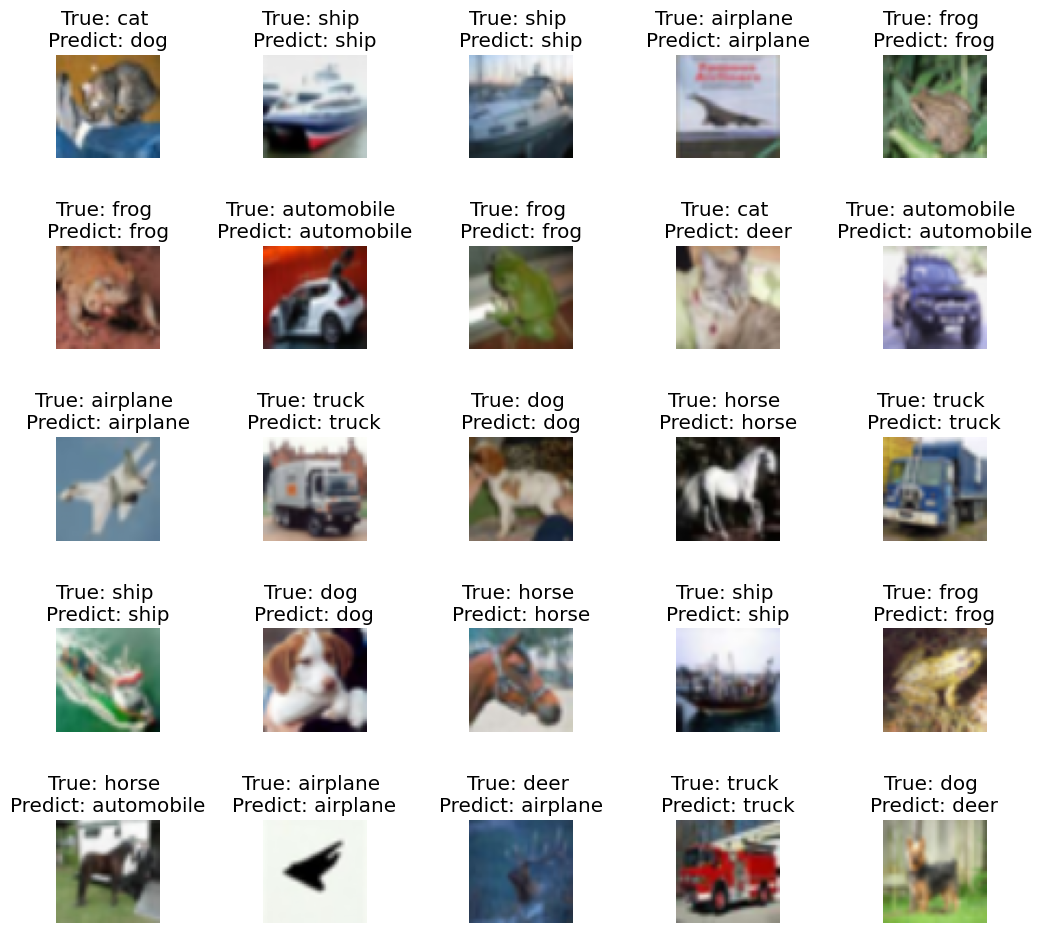

In [51]:
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
  axes[i].imshow(X_test[i])
  axes[i].set_title("True: %s \nPredict: %s" %(classes[np.argmax(Y_test[i])],
                                               classes[predictions[i]]))
  axes[i].axis('off')
  plt.subplots_adjust(wspace=1)
